# Macaque FLN Link-Node Community Walkthrough
Authored by Jorge S. Martinez Armas.

This notebook guides you through the macaque cortical hierarchy analysis introduced in Martinez Armas et al. (2024) [`doi:10.1101/2024.08.07.606907`](https://doi.org/10.1101/2024.08.07.606907). We reproduce the main figures by:
- downloading the 40d91 fraction of labeled neurons (FLN) connectome from Core-Nets,
- fitting the LinkNodeCommunity clustering model with Hellinger similarity on the edge-complete subgraph,
- extracting the Goldilocks level (maximum loop entropy `S`) and its node cover,
- recreating the visualizations that appear in the paper.

The walkthrough assumes that the LinkNodeCommunity package is installed from this repository and that the required R packages (`ggtree`, `latex2exp`, `ggplot2`, `ape`) are available through `rpy2`. If you are running the notebook for the first time, install those dependencies before executing the R cells.


## Step 0 · Configure the Python environment
Import the scientific stack, expose `src/` on `sys.path`, and load the LinkNodeCommunity package and macaque dataset helper.


In [1]:
import numpy as np
import networkx as nx
import sys
import os

# Add the parent directory to sys.path so src can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import LinkNodeCommunity as linknode
from src.io.loader import load_macaque_fln_40d91

## Step 1 · Load the macaque FLN connectome
`load_macaque_fln_40d91` retrieves the directed edge list, cortical labels, and color palette from the Core-Nets repository (dataset 40d91). It caches the raw files under `../data/macaque` by default; set `path` to reuse an existing download.


In [2]:
# Download the macaque FLN dataset from core-nets.org
edgelist, labels, regions, colors = load_macaque_fln_40d91(path="../data/macaque")

## Step 2 · Restrict to reciprocally connected cortical areas
The paper focuses on the edge-complete subgraph where every region has both incoming and outgoing links. Working on this subgraph keeps the link similarity neighborhoods comparable across areas.


In [3]:
# Create directed graph from edge list
G = nx.DiGraph()
G.add_weighted_edges_from(edgelist[:, :3])

# Since the graph is directed and some nodes are only sources or only targets,
# we need to find the intersection of source and target nodes for clustering.
sources = set(u for u, _, _ in G.edges(data=True))
targets = set(v for _, v, _ in G.edges(data=True))
intersection_nodes = sources & targets
# Create a subgraph with only the intersection nodes
edge_complete_subgraph = G.subgraph(intersection_nodes)

## Step 3 · Fit the link hierarchy with Bhattacharyya coefficient
We initialize the `Clustering` model on the full graph but evaluate similarities on the edge-complete subgraph (`consider_subgraph=True`). Bhattacharyya coefficient (`1 - H^2`) stays in `[0, 1]`, so we keep `max_dist=1.0` throughout the pipeline.


In [4]:
%%time

# We use the Bhattacharyya coefficient as the similarity index.
# Similarity calculations use the full graph, but clustering is performed only on the edge-complete subgraph.
# This leverages all available information for improved similarity estimates.
# Note: The similarity index should be in [0, 1] for this method to work properly.
# The Bhattacharyya coefficient is defined as 1 - H^2, where H is the Hellinger distance,
# so it naturally falls within the [0, 1] range.

# The consider_subgraph=True argument ensures that only links in the edge-complete subgraph are clustered,
# which is crucial for directed graphs where some nodes may lack both incoming and outgoing edges.
# The full graph is still used to compute similarities, providing richer context for clustering.

model = linknode.Clustering(G, similarity_index="bhattacharyya_coefficient", consider_subgraph=True)
model.fit_linksim_edgelist(use_parallel=True)

# We need to populate the link distance edgelist or matrix before processing features
# Here we use the edgelist approach

model.fit_linkdist_edgelist()

# NOTE: The dissimilarity matrix are in [0, 1], so max_dist should be set accordingly.
# Another option is to used the convert to a distance metric.
# For the Hellinger distance, sqrt(2)H is a proper distance metric.
# Since we use the single-linkage criterion to cluster links,
# the difference between using H or sqrt(2)H is negligible because of the monotonic transformation.

CPU times: user 30 ms, sys: 5.78 ms, total: 35.8 ms
Wall time: 41.8 ms


## Step 4 · Compute link hierarchy statistics
`process_features_edgelist` summarizes each cut height with the loop entropy `S`, link density `D`, link counts, and other diagnostics. These statistics drive the Goldilocks selection used in the paper.


In [5]:
%%time
# NOTE: To compute the link hierarchy statistics for downstream analysis,
# we need to extract the edge list from the edge-complete subgraph.
# Convert edge_complete_subgraph edges to a numpy array of shape (M, 3): [source, target, weight]

from src.LinkNodeCommunity.utils import edgelist_from_graph
model.edgelist = edgelist_from_graph(edge_complete_subgraph)

link_hierarchy_statistic = model.process_features_edgelist(max_dist=1.0) # max_dist for the squared Hellinger distance (H^2 = 1)

CPU times: user 145 ms, sys: 6.61 ms, total: 152 ms
Wall time: 330 ms


## Step 5 · Inspect the hierarchy diagnostics
The left panel tracks how dense the link communities remain (`D`), while the right panel highlights where the loop entropy `S` peaks. The Goldilocks point balances the two, signalling a meaningful partition.


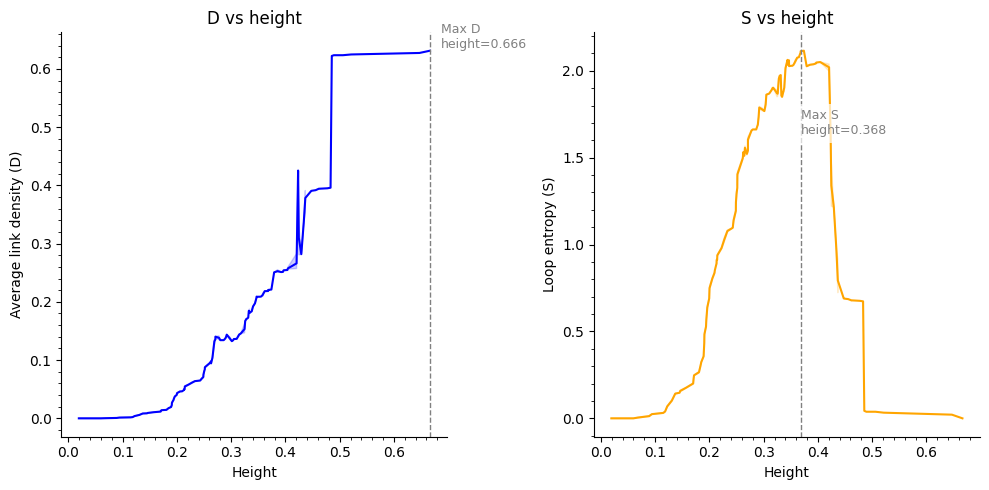

In [6]:
import matplotlib.pyplot as plt
from src.viz.graphics import link_statistics_graph

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
link_statistics_graph(
    linkstats=link_hierarchy_statistic,
    x="height",
    y="D",
    xlabel="Height",
    ylabel="Average link density (D)",
    testxoffset=0.02,
    color="blue",
    ax=axes[0]
)

link_statistics_graph(
    linkstats=link_hierarchy_statistic,
    x="height",
    y="S",
    xlabel="Height",
    ylabel="Loop entropy (S)",
    textyoffset=-0.5,
    color="orange",
    ax=axes[1]
)
fig.tight_layout()
plt.show()

## Step 6 · Derive the node hierarchy
`node_community_hierarchy_edgelist` converts the link dendrogram into its induced node hierarchy, keeping the Hellinger distances aligned with the link-level merges.


In [7]:
%%time
# Get the node community hierarchy (linkage matrix Z)
# and linknode_equivalence to node hierarchy partition from
# link hierarchy statistics

model.node_community_hierarchy_edgelist(use_parallel=True, max_dist=1.0) # max_dist for the squared Hellinger distance (H^2 = 1)

CPU times: user 51.7 ms, sys: 1.42 ms, total: 53.1 ms
Wall time: 62.2 ms


## Step 7 · Prepare the dendrogram visualization
We export the linkage matrix to Newick format and ready the `rpy2` bridge. Ensure your R environment provides `ggtree`, `latex2exp`, `ggplot2`, and `ape` before running the next cell.


In [8]:
# To visualize the node hierarchy as in the main paper,
# we need to convert the linkage matrix to Newick format
# and use R's ggtree package to plot it.

model.to_newick(labels=labels[:model.N]) # Since there are more labels than nodes in the intersection subgraph
                                         # we only use the first N labels
 

%load_ext rpy2.ipython

# Prepare variables to pass into R
model_newick = model.newick
# Use the last merge height from the linkage matrix (column 2 in Python, 0-indexed)
root_position = 1 - model.Z[-1, 2]

## Step 8 · Plot the Goldilocks dendrogram in R
The `ggtree` visualization mirrors the paper: the horizontal axis is the Hellinger-based similarity scale (`S = 1 - H^2`), so the root appears at the maximum entropy height.


ggtree v3.16.3 Learn more at https://yulab-smu.top/contribution-tree-data/

Please cite:

Guangchuang Yu. Using ggtree to visualize data on tree-like structures.
Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96

Attaching package: ‘ape’

The following object is masked from ‘package:ggtree’:

    rotate



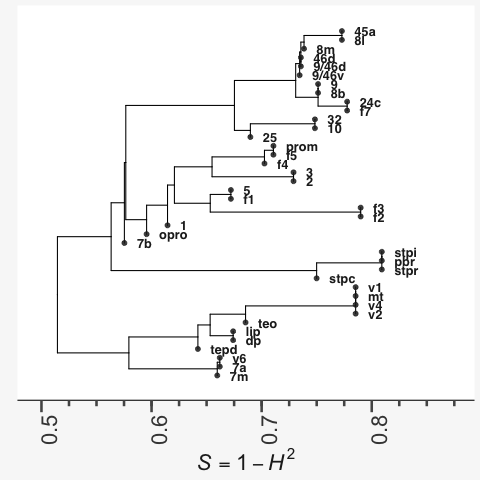

In [9]:
%%R -i model_newick -i root_position

library(ggplot2)
library(latex2exp)
library(ggtree)
library(grid)
library(ape)

# Build tree from Newick string passed in from Python
tree <- read.tree(text = model_newick)

offset <- 0.01

p <- ggtree(
  tree, layout = "rectangular", root.position = root_position
) +
  geom_tippoint(size = 2, color = "#222222", alpha = 0.85) +
  geom_tiplab(
    size = 4.5,
    fontface = "bold",
    angle = 0, offset = offset, hjust = 0,
    color = "#222222"
  )  +
  vexpand(0.04, direction = -1) +
  vexpand(0.04, direction = 1) +
  hexpand(0.04, direction = -1) +
  hexpand(0.07, direction = 1) +
  guides(
    x = guide_axis(minor.ticks = TRUE)
  ) +
  scale_x_continuous(
    minor_breaks = scales::breaks_width(0.025),
    expand = expansion(mult = c(0.02, 0.08))
  ) +
  theme_tree2(
    axis.text.x = element_text(size = 22, angle = 90, color = "#444444"),
    axis.ticks.length = unit(12, "pt"),
    axis.minor.ticks.length = unit(6, "pt"),
    axis.ticks.x = element_line(linewidth = 1.2, color = "#555555"),
    axis.ticks.length.x = unit(12, "pt"),
    axis.title.x = element_text(size = 22, face = "bold", color = "#222222"),
    plot.background = element_rect(fill = "#f8f8f8", color = NA)
  ) +
  labs(x = TeX("$S=1-H^{2}$", italic = TRUE))

print(p)

## Step 9 · Locate the Goldilocks partition
`linknode_equivalence_partition` scans the hierarchy for the maximum `S` score and returns the number of link and node communities as well as the cut height.


In [10]:
# To visualize the partition at the Goldilocks level (maximum S),
# we find the corresponding height and use it to cut the tree.

from src.LinkNodeCommunity.utils import linknode_equivalence_partition

number_link_communities, \
    number_node_communities, \
        height_at_maximum = linknode_equivalence_partition(
            score="S",
                linkstats=link_hierarchy_statistic,
                    linknode_equivalence=model.linknode_equivalence
                        )

print(f"Number of link communities (K) at maximum S: {number_link_communities}")
print(f"Corresponding number of node communities (R): {number_node_communities}")
print(f"Height at maximum S: {height_at_maximum}")

Number of link communities (K) at maximum S: 56
Corresponding number of node communities (R): 9
Height at maximum S: 0.36822972016747413


## Step 10 · Compute node overlap communities
We cut the dendrogram at the Goldilocks height, relabel the nodes sequentially, and fit `NOCFinder` to recover the node overlap covers using the precomputed link similarities.


In [11]:
# Cut the tree at the height corresponding to maximum S
from src.LinkNodeCommunity.utils import cut_tree_with_validation, collapsed_partition, linear_partition

node_partition = cut_tree_with_validation(model.Z, number_node_communities)
node_partition = collapsed_partition(node_partition)  # Collapse to consecutive integers starting from 0
node_partition = linear_partition(node_partition)

# Compute NOCs using the node partition
nocs_model = linknode.NOCFinder(
    edge_complete_subgraph, node_partition,
    undirected=False,
    labels=labels[:model.N],
    similarity_index="bhattacharyya_coefficient",
    tie_policy="include_equal"
)

# Fit the NOC model using the precomputed link similarity matrices
# It will populate the NOC attributes
nocs_model.fit(model.linksim.source_sim_matrix, model.linksim.target_sim_matrix)

## Step 11 · Visualize node overlap communities on the network
The distance-aware Kamada-Kawai layout emphasizes strongly connected pairs. `graph_network_covers` overlays the node cover assignments and highlights singletons reported by the model.


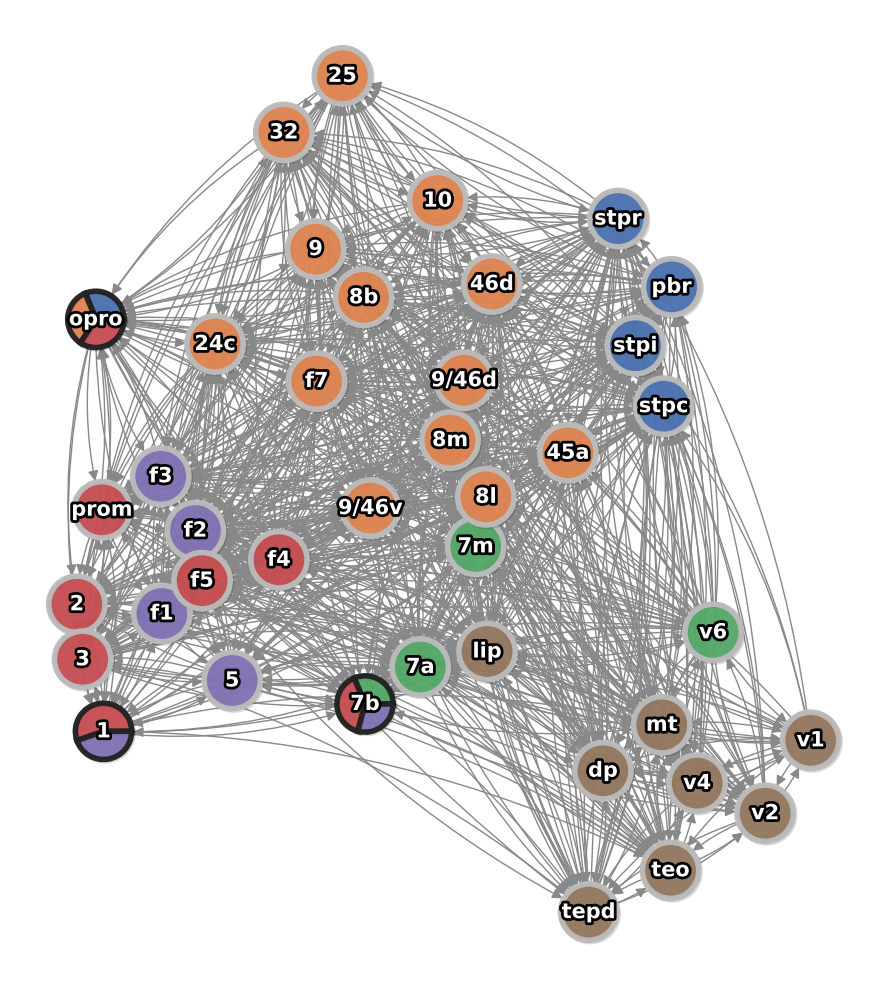

In [12]:
# Visualize the NOCs on a 2D network layout

from src.viz.graphics import graph_network_covers

label_offsets = {
    "v1": np.array([0.05, 0]),
    "v2": np.array([0, -0.1]),
    "46d": np.array([0.05, 0.05]),
    "9/46d": np.array([0, -0.05]),
    "f4": np.array([0.05, 0.05])
}

# Transform edge weights for layout computation
G_dist = edge_complete_subgraph.copy()
for _, _, d in G_dist.edges(data=True):
    w = d.get("weight", 1.0)
    # Avoid log(0) or negative/zero weights
    w = max(w, 1e-10)
    d["distance"] = -np.log(w)

# Use -log(w) as the distance for kamada_kawai_layout
pos = nx.kamada_kawai_layout(
    G_dist, 
    weight="distance"
)

fig, ax = plt.subplots(figsize=(10, 10))

graph_network_covers(
    G_dist,
    pos,
    nocs_model.node_cover_partition,
    node_partition,
    nocs_model.single_node_cover_map,
    nocs_model.single_nodes_cover_scores,
    labels=labels[:model.N],
    palette="deep",
    scale=0.7,
    arrowsize=15,
    font_size=15,
    stroke_linewidth=4,
    hide_labels=False,
    label_offsets=label_offsets,
    ax=ax
)


## Step 12 · Inspect the link community matrix
`linkcommunity_matrix_map` reorders the adjacency matrix according to the Goldilocks partition, revealing the block structure captured by the link communities.


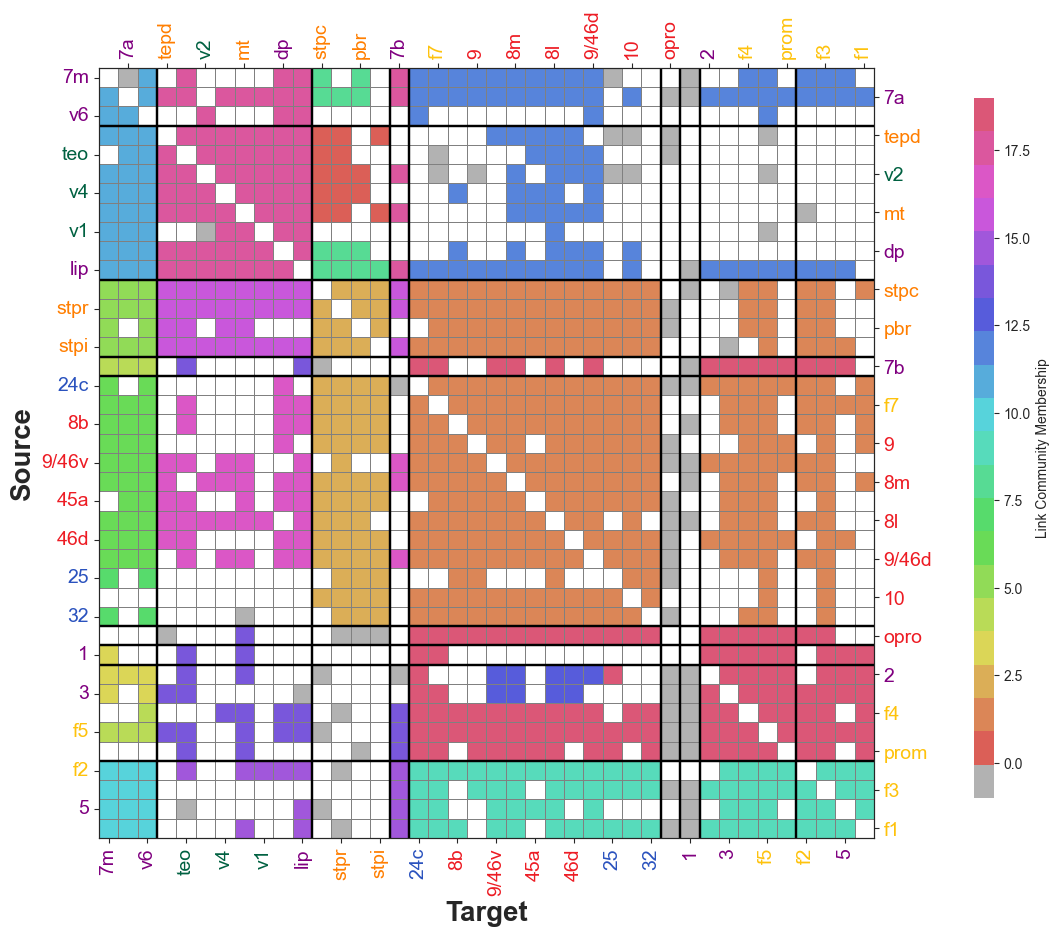

In [13]:
# Finally, visualize the link community matrix at the Goldilocks level
from src.viz.graphics import linkcommunity_matrix_map

linkcommunity_matrix_map(
    edge_complete_subgraph,
    model.get_hierarchy_edgelist(1.0),
    model.Z,
    number_link_communities,
    number_node_communities,
    labels=labels[:model.N],
    colors=colors[:model.N],
    linewidth=1.75,
    palette="hls",
)

## Step 13 · Map connection-strength features

`heatmap` mirrors `linkcommunity_matrix_map` but encodes the FLN weights instead of binary connectivity. Dark tiles mark missing projections, whereas bright ones expose strong interareal links that extend beyond the meso-scale communities. Apparent symmetries arise because many cortical dyads are reciprocally connected; nevertheless the map reveals asymmetries such as the outgoing projections from the primary visual system (V1, V2, etc.) to the somatosensory-premotor-motor cluster (areas 2, 3, F1, F2, etc.), which underscores divergent feed-forward and feedback pathways.


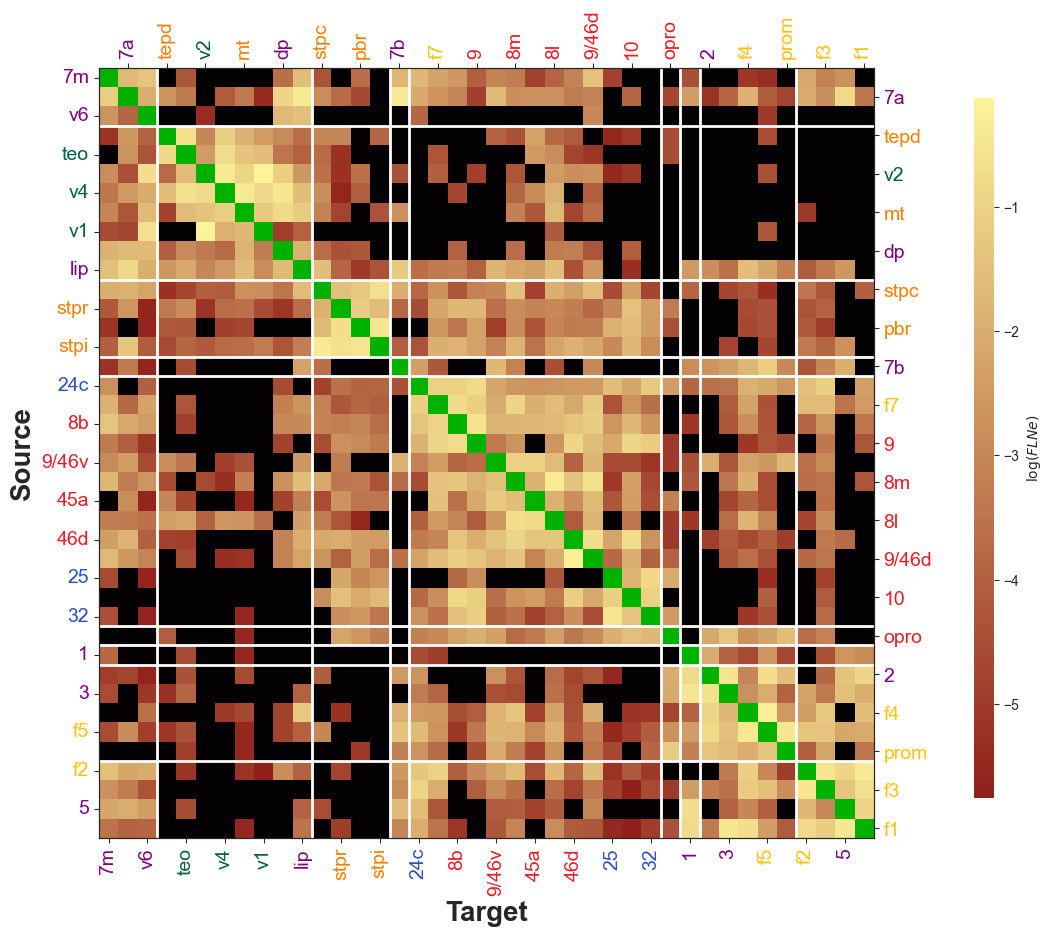

In [14]:
from src.viz.graphics import heatmap

G_log = edge_complete_subgraph.copy()
edges_to_remove = []
for u, v, d in G_log.edges(data=True):
    w = d.get("weight", 1.0)
    if w == 0:
        edges_to_remove.append((u, v))
    else:
        # Avoid log(0) or negative/zero weights
        w = max(w, 1e-10)
        d["weight"] = np.log10(w)
G_log.remove_edges_from(edges_to_remove)

heatmap(
    G_log,
    model.Z,
    number_node_communities,
    labels=labels[:model.N],  # Since there are more labels than nodes in the intersection subgraph
    colors=colors[:model.N],
    center=-3,
    heatmap_linewidths=0.0,
    cbar_position=[1.0, 0.15, 0.02, 0.7],
    community_boundaries=2,
    cbar_label=r"$\log(FLNe)$",
    remove_labels=False
)

## Observations

- The edge-complete subgraph emphasises prefrontal, parietal, and temporal cortices, echoing the modules reported in Martinez Armas et al. (2024).
- The Goldilocks height maximises loop entropy while preserving dense link bundles, matching the interpretation in the paper.
- Node overlap communities identify multi-area hubs (for example 7b, 1, and OPRO) that bridge sensory and association circuits.
- The weight heatmap from Step 13 surfaces directional asymmetries—such as visual-to-motor feed-forward links—that are muted in the binary matrix.
- Vary the similarity index or tie policy if you want to stress-test the partition; the plotting utilities adapt automatically and the storyline above still guides the interpretation.
